# Parse static networks

Parses nursing home interaction data that is temporally resolved to create a static interaction network between patients (and employees). The link strength corresponds to different shared living areas:
* strong: shared room
* moderate: shared table
* weak: shared living area

**Note**: right now, stronger links supercede weaker links and do not "add up"

In [22]:
import pandas as pd
import networkx as nx
import itertools
from os.path import join

## Single quarters

In [27]:
WB = 2

data = pd.read_csv('../../../data/nursing_homes/WB{}_combined_clean.csv'.format(WB),
                  usecols=['week', 'ID', 'Wohnbereich', 'Tischnummer', 
                           'Zimmernummer', 'Covid19_pos'],
                  parse_dates=['week'])

weeks = list(data['week'].unique())
weeks.sort()

In [28]:
data = data[data['week'] == pd.to_datetime('2020-02-03')]
data = data[data['Wohnbereich'] == WB]
data = data.rename(columns={'Zimmernummer':'close', 'Tischnummer':'intermediate',
                           'Wohnbereich':'far'})
# rename patient IDs
data['ID'] = ['r{}'.format(i) for i in range(1, len(data) + 1)]

### Shared rooms

In [29]:
data['close'].value_counts()

106B    3
1V08    3
106A    2
109B    2
107A    2
108B    2
104B    2
109A    2
104A    2
7B      1
108A    1
1N10    1
1V09    1
107B    1
105B    1
1088    1
1V12    1
1N04    1
1N11    1
1VF     1
1V07    1
1N09    1
1058    1
Name: close, dtype: int64

### Shared tables

In [30]:
data['intermediate'].value_counts()

7.0    5
6.0    5
8.0    4
3.0    4
5.0    3
1.0    3
2.0    2
9.0    1
Name: intermediate, dtype: int64

In [49]:
def ConstructNetwork(data, quarter, N_employees):
    G = nx.Graph()
    resident_IDs = data['ID']
    
    ## resident contacts ###
    # order is important here, since strongest links are added first and then
    # not replaced by weaker links if they already exist
    contact_types = ['close','intermediate','far']
    link_types = {'close':'resident_resident_room', 
                  'intermediate':'resident_resident_table',
                  'far':'resident_resident_quarters'}
    for ct in contact_types:
        # iterate over all sub-units of the given contact type, for example the
        # different room or table numbers in the case of nursing homes
        for sub_ct in data[ct].unique():
            sub_ct_data = data[data[ct] == sub_ct]
            # create a list of all possible ID-tuples from all IDs that share
            # a given sub-unit (e.g. all residents that share a room or
            # all residents that have lunch on the same table)
            ID_tuples = [tuple(i) for \
                    i in itertools.combinations(sub_ct_data['ID'].values, 2)]
            # add all the links from the sub area to the graph
            for tup in ID_tuples:
                edge_data = G.get_edge_data(tup[0], tup[1])
                if edge_data == None:
                    G.add_edge(tup[0], tup[1], contact_type=ct, 
                               link_type = link_types[ct])
                    
    nx.set_node_attributes(G, 'Q{}'.format(quarter), 'unit')
    nx.set_node_attributes(G, 'resident', 'type')
    nx.set_node_attributes(G, 'age', 80)
    
    ## employee contacts ##
    # create a complete contact graph for the employees, as they all interact
    # with each other
    employee_IDs = ['e{}'.format(i) for i in \
                    range((quarter - 1) * N_employees, quarter * N_employees)]
    H = nx.complete_graph(employee_IDs)
    nx.set_node_attributes(H, {eID:{'type':'employee', \
                                    'unit':'Q{}'.format(quarter),
                                    'age':35}\
                           for eID in employee_IDs})
    nx.set_edge_attributes(H, 'far', 'contact_type')
    nx.set_edge_attributes(H, 'employee_employee_short', 'link_type')
    
    # add the employee contacts to the resident contacts
    G = nx.compose(G, H)
    for e in employee_IDs:
        for r in resident_IDs:
            # every employee has contact with every resident
            G.add_edge(e, r, contact_type='far', 
                       link_type='employee_resident_care')
    
    return G

In [51]:
dst = '../data/nursing_home'

In [52]:
G = ConstructNetwork(data, 1, 18)
nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_single_quarter.bz2'\
                                  .format(WB)), protocol=4)

## Facility with several quarters

In [53]:
def add_mobility_links(G, patients_q1, patients_q2, N):
    mobile_patients = patients_q1.sample(N)
    friends = patients_q2.sample(N)
    
    for m, f in zip(mobile_patients, friends):
        #print('added edge {} -> {}'.format(m, f))
        G.add_edge(m, f, area='facility')
        
    return G

### Two quarters

In [54]:
# rename patient IDs
data_q1 = data.copy()
data_q2 = data.copy()
data_q1['ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['ID'] = ['p{}'.format(i) for i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)

G = nx.compose(H, I)

# add random week links between the four quarters through mobile patients
G = add_mobility_links(G, data_q1['ID'], data_q2['ID'], 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_2_quarters.bz2'\
                                  .format(WB)))

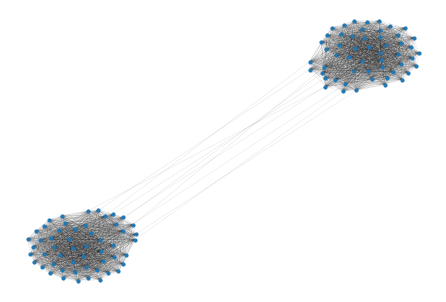

In [55]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)

### Three quarters

In [56]:
# rename patient IDs
data_q1 = data.copy()
data_q2 = data.copy()
data_q3 = data.copy()
data_q1['ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['ID'] = ['p{}'.format(i) for i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
data_q3['ID'] = ['p{}'.format(i) for i in range(2 * len(data_q3) + 1, 3 * len(data_q3) + 1)]

H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)
J = ConstructNetwork(data_q3, 3, 18)

G = nx.compose(H, I)
G = nx.compose(G, J)

# add random week links between the four quarters through mobile patients
G = add_mobility_links(G, data_q1['ID'], data_q2['ID'], 10)
G = add_mobility_links(G, data_q1['ID'], data_q3['ID'], 10)
G = add_mobility_links(G, data_q2['ID'], data_q3['ID'], 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_3_quarters.bz2'\
                                  .format(WB)))

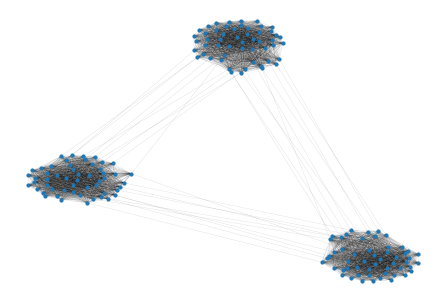

In [57]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)

### Four quarters

In [58]:
# rename patient IDs
data_q1 = data.copy()
data_q2 = data.copy()
data_q3 = data.copy()
data_q4 = data.copy()
data_q1['ID'] = ['p{}'.format(i) for i in range(1, len(data_q1) + 1)]
data_q2['ID'] = ['p{}'.format(i) for i in range(len(data_q2) + 1, 2 * len(data_q2) + 1)]
data_q3['ID'] = ['p{}'.format(i) for i in range(2 * len(data_q3) + 1, 3 * len(data_q3) + 1)]
data_q4['ID'] = ['p{}'.format(i) for i in range(3 * len(data_q4) + 1, 4 * len(data_q4) + 1)]

H = ConstructNetwork(data_q1, 1, 18)
I = ConstructNetwork(data_q2, 2, 18)
J = ConstructNetwork(data_q3, 3, 18)
K = ConstructNetwork(data_q4, 4, 18)

G = nx.compose(H, I)
G = nx.compose(G, J)
G = nx.compose(G, K)

# add random week links between the four quarters through mobile patients
G = add_mobility_links(G, data_q1['ID'], data_q2['ID'], 10)
G = add_mobility_links(G, data_q1['ID'], data_q3['ID'], 10)
G = add_mobility_links(G, data_q1['ID'], data_q4['ID'], 10)
G = add_mobility_links(G, data_q2['ID'], data_q3['ID'], 10)
G = add_mobility_links(G, data_q2['ID'], data_q4['ID'], 10)
G = add_mobility_links(G, data_q3['ID'], data_q4['ID'], 10)

nx.readwrite.gpickle.write_gpickle(G, join(dst,'interactions_4_quarters.bz2'\
                                  .format(WB)))

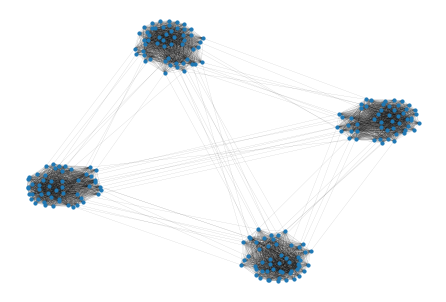

In [19]:
pos = nx.drawing.layout.spring_layout(G, dim=2)
nx.draw(G, pos, node_size=10, width=0.05)